In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

### Import data

In [2]:
mta_data = pd.read_pickle('mta_2018')

### Clean columns

In [3]:
# reset mta data index
mta_data.reset_index(drop=True,inplace=True)

# rename column EXITS
mta_data.rename(columns={'EXITS                                                               ':'EXITS'},inplace=True)

In [4]:
# Create DateTime column
mta_data['DATETIME'] = pd.to_datetime(mta_data.DATE + ' ' + mta_data.TIME)
mta_data['DATE']= pd.to_datetime(mta_data['DATE'])

# Find median_hour (center of the time slot)
# Corresponds to 2am, 6am, 10am, 14=2pm,...
mta_data['HOUR'] = (((mta_data['DATETIME'].diff()/2).shift(-1) + mta_data['DATETIME']).dt.hour)
mta_data.dropna(how='any',subset=['HOUR'],inplace=True)
mta_data['HOUR'] = mta_data['HOUR'].astype('int')

# Create Day of Week from newly create DateTime column
mta_data['WEEKDAY'] = mta_data['DATETIME'].dt.day_name()
# Create day_of_week column
mta_data['dow'] = mta_data['DATETIME'].apply(lambda x: x.weekday())


In [5]:
# Create Unique Daily ID for each turnstile
mta_data['UNIQUEID'] = mta_data['STATION'] + '_' + mta_data['UNIT'] + '_' + mta_data['C/A'] \
+ '_' + mta_data['SCP']

### Find entries for each row

In [6]:
# clean ENTRIES/EXITS as they are cumulative data
mta_data['ENTRYDIFF'] = mta_data.ENTRIES.diff()
mta_data['EXITDIFF'] = mta_data.EXITS.diff()
mta_data = mta_data[(mta_data['ENTRYDIFF'] < 100000) & (mta_data['ENTRYDIFF'] > 0)]
mta_data = mta_data[(mta_data['EXITDIFF'] < 100000) & (mta_data['EXITDIFF'] > 0)]
mta_data['TRAFFIC'] = mta_data['ENTRYDIFF'] + mta_data['EXITDIFF']

In [7]:
mta_data['TRAFFIC'].min(), mta_data['TRAFFIC'].mean(), mta_data['TRAFFIC'].max()

(2.0, 404.47821081453253, 159174.0)

In [8]:
# Find time_span (hr) between each row
# Note that most are 4.0 hrs but some are not
mta_data['DURATION'] = mta_data.DATETIME.diff().apply(lambda x: x.total_seconds()/3600)

In [9]:
# Find avg_entries (entries per hour)
mta_data['AVG_TRAFFIC'] = mta_data['TRAFFIC']/ mta_data['DURATION']

In [10]:
# Drop unnecessary columns
mta_data.drop(columns=['DATE','TIME','C/A','UNIT','SCP','LINENAME','DESC','ENTRIES','EXITS'],inplace=True)

In [11]:
mta_data.head()

,STATION,DIVISION,DATETIME,HOUR,WEEKDAY,dow,UNIQUEID,ENTRYDIFF,EXITDIFF,TRAFFIC,DURATION,AVG_TRAFFIC
1,59 ST,BMT,2018-05-12 04:00:00,6,Saturday,5,59 ST_R051_A002_02-00-00,19.0,5.0,24.0,NaN,NaN
2,59 ST,BMT,2018-05-12 08:00:00,10,Saturday,5,59 ST_R051_A002_02-00-00,19.0,31.0,50.0,4.0,12.50
3,59 ST,BMT,2018-05-12 12:00:00,14,Saturday,5,59 ST_R051_A002_02-00-00,105.0,85.0,190.0,4.0,47.50
4,59 ST,BMT,2018-05-12 16:00:00,18,Saturday,5,59 ST_R051_A002_02-00-00,219.0,49.0,268.0,4.0,67.00
5,59 ST,BMT,2018-05-12 20:00:00,22,Saturday,5,59 ST_R051_A002_02-00-00,297.0,50.0,347.0,4.0,86.75


### Choose station

In [12]:
# Choose penn station data
penn_df = mta_data[mta_data.STATION == '34 ST-PENN STA'].iloc[1:].reset_index()

# Filter for entries between 0 and 3000
# Outliers come from switching to next turnstiles (should be the same as dropping first rows of each turnstile)
# Filter out the negative values of avg_entries
# (should be the same as dropping first value of each turnstile on a new day)
penn_filter = penn_df[(penn_df.TRAFFIC<100000) & (penn_df.TRAFFIC>0)].copy()

Check if the value of entries make sense:

In [13]:
penn_filter.TRAFFIC.min(),penn_filter.TRAFFIC.mean(),penn_filter.TRAFFIC.max()

(2.0, 492.9517246061923, 3541.0)

In [14]:
# Check if values of avg_entries make sense
# Found negative values: happens when switching to next turnsiles
penn_filter['AVG_TRAFFIC'].min(), penn_filter['AVG_TRAFFIC'].mean(), penn_filter['AVG_TRAFFIC'].max()

(-3.75, 123.38552558839368, 885.25)

In [15]:
penn_filter = penn_filter[penn_filter['AVG_TRAFFIC'] > 0]
penn_filter['AVG_TRAFFIC'] = penn_filter['AVG_TRAFFIC'].astype(int)

In [16]:
# There are 92 turnstiles in Penn station?
penn_filter.UNIQUEID.nunique()

92

In [17]:
penn_filter.AVG_TRAFFIC.min(),penn_filter.AVG_TRAFFIC.mean(),penn_filter.AVG_TRAFFIC.max()

(0, 126.17610194276165, 885)

In [18]:
penn_filter

,index,STATION,DIVISION,DATETIME,HOUR,WEEKDAY,dow,UNIQUEID,ENTRYDIFF,EXITDIFF,TRAFFIC,DURATION,AVG_TRAFFIC
0,50310,34 ST-PENN STA,IND,2018-05-12 08:00:00,10,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,28.0,43.0,71.0,4.0,17
1,50311,34 ST-PENN STA,IND,2018-05-12 12:00:00,14,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,95.0,116.0,211.0,4.0,52
2,50312,34 ST-PENN STA,IND,2018-05-12 16:00:00,18,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,150.0,150.0,300.0,4.0,75
3,50313,34 ST-PENN STA,IND,2018-05-12 20:00:00,22,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,105.0,157.0,262.0,4.0,65
4,50314,34 ST-PENN STA,IND,2018-05-13 00:00:00,2,Sunday,6,34 ST-PENN STA_R012_N067_00-00-00,41.0,56.0,97.0,4.0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14723,722622,34 ST-PENN STA,IRT,2018-06-08 02:00:00,4,Friday,4,34 ST-PENN STA_R293_R142_01-06-01,74.0,43.0,117.0,4.0,29
14724,722624,34 ST-PENN STA,IRT,2018-06-08 10:00:00,12,Friday,4,34 ST-PENN STA_R293_R142_01-06-01,100.0,498.0,598.0,8.0,74
14725,722625,34 ST-PENN STA,IRT,2018-06-08 14:00:00,16,Friday,4,34 ST-PENN STA_R293_R142_01-06-01,166.0,283.0,449.0,4.0,112
14726,722626,34 ST-PENN STA,IRT,2018-06-08 18:00:00,20,Friday,4,34 ST-PENN STA_R293_R142_01-06-01,244.0,416.0,660.0,4.0,165


In [19]:
# Sum over all turnstiles
penn_total = penn_filter.groupby(["dow","HOUR"])['AVG_TRAFFIC'].sum().reset_index()
# penn_total

In [20]:
penn_total.AVG_TRAFFIC.sum()/28 # avg_entries is 35144!

64714.82142857143

In [21]:
# Compare group station and sum
penn_total_test = penn_filter.groupby(["STATION"])['AVG_TRAFFIC'].sum().reset_index()
penn_total_test.AVG_TRAFFIC.sum()/28

64714.82142857143

In [22]:
# Average over day
penn_total_byday = penn_total.groupby("HOUR")['AVG_TRAFFIC'].mean().reset_index()
penn_total_byday['AVG_TRAFFIC'] = penn_total_byday['AVG_TRAFFIC'].astype(int)
penn_total_byday

,HOUR,AVG_TRAFFIC
0,0,15235
1,2,18824
2,3,1100
3,4,3964
4,5,80
5,6,2543
6,7,382
7,8,1347
8,10,27822
9,11,3002


<ipython-input-23-ba68365d7de8>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['10k','20k','30k','40k','50k','60k','70k'])


[Text(0, 0.0, '10k'),
 Text(0, 10000.0, '20k'),
 Text(0, 20000.0, '30k'),
 Text(0, 30000.0, '40k'),
 Text(0, 40000.0, '50k'),
 Text(0, 50000.0, '60k'),
 Text(0, 60000.0, '70k'),
 Text(0, 70000.0, '')]

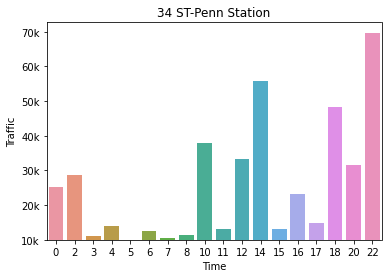

In [23]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_total_byday)
ax.set_title('34 ST-Penn Station')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic')
ax.set_yticklabels(['10k','20k','30k','40k','50k','60k','70k'])

Text(0, 0.5, 'Traffic')

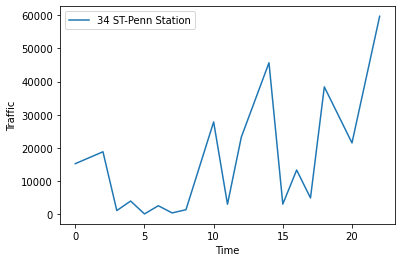

In [24]:
# Same data shown in lineplot (can overlap with data from other stations)
ax = sns.lineplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_total_byday, label='34 ST-Penn Station')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Traffic')

In [25]:
# Day of week daily entries
# Sum over all turnstiles
# penn_total = penn_filter2.groupby(["day_of_week","median_hour"])['avg_entries'].sum().reset_index()

# Sum over hours for one day
penn_total_byweek = penn_total.groupby("dow")['AVG_TRAFFIC'].sum().reset_index()
penn_total_byweek['AVG_TRAFFIC'] = penn_total_byweek['AVG_TRAFFIC'].astype(int)
penn_total_byweek

,dow,AVG_TRAFFIC
0,0,260867
1,1,315699
2,2,322622
3,3,328071
4,4,311001
5,5,132181
6,6,141574


[Text(0, 0, 'Mon'),
 Text(1, 0, 'Tue'),
 Text(2, 0, 'Wed'),
 Text(3, 0, 'Thu'),
 Text(4, 0, 'Fri'),
 Text(5, 0, 'Sat'),
 Text(6, 0, 'Sun')]

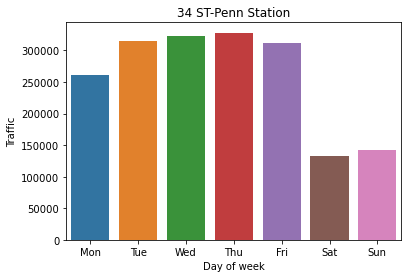

In [26]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='dow', y= 'AVG_TRAFFIC', data = penn_total_byweek)
ax.set_title('34 ST-Penn Station')
ax.set_xlabel('Day of week')
ax.set_ylabel('Traffic')
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
# ax.set_yticklabels(['50k','100k','150k','200k','250k','300k'])

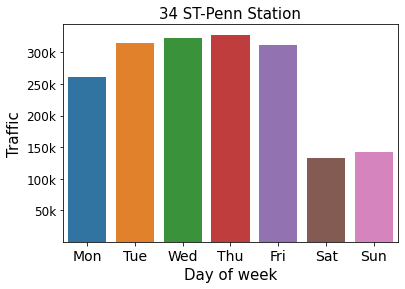

In [27]:
fig, ax = plt.subplots()
ax = sns.barplot(x='dow', y= 'AVG_TRAFFIC', data = penn_total_byweek)
ax.set_title('34 ST-Penn Station',fontsize=15)
ax.set_xlabel('Day of week',fontsize=15)
ax.set_ylabel('Traffic',fontsize=15)
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],fontsize=14)

ax.set_yticks([5e4,10e4,15e4,20e4,25e4,30e4])
ax.set_yticklabels(['50k','100k','150k','200k','250k','300k'],fontsize=12)
fig.savefig('Traffic_dayofweek.pdf', bbox_inches='tight')

In [28]:
# Check the daily entries

##  COMMENT THIS OUT  -AB
#penn_total_byday.avg_entries.mean(),penn_total_byday.avg_entries.mean()*24

In [29]:
penn_total_byday.AVG_TRAFFIC.mean(),penn_total_byday.AVG_TRAFFIC.mean()*24

(15782.111111111111, 378770.6666666667)

In [30]:
# weekday/weekend
penn_weekday = penn_filter[penn_filter['dow'] < 5]
penn_weekend = penn_filter[penn_filter['dow'] >= 5]

In [31]:
penn_weekend

,index,STATION,DIVISION,DATETIME,HOUR,WEEKDAY,dow,UNIQUEID,ENTRYDIFF,EXITDIFF,TRAFFIC,DURATION,AVG_TRAFFIC
0,50310,34 ST-PENN STA,IND,2018-05-12 08:00:00,10,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,28.0,43.0,71.0,4.0,17
1,50311,34 ST-PENN STA,IND,2018-05-12 12:00:00,14,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,95.0,116.0,211.0,4.0,52
2,50312,34 ST-PENN STA,IND,2018-05-12 16:00:00,18,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,150.0,150.0,300.0,4.0,75
3,50313,34 ST-PENN STA,IND,2018-05-12 20:00:00,22,Saturday,5,34 ST-PENN STA_R012_N067_00-00-00,105.0,157.0,262.0,4.0,65
4,50314,34 ST-PENN STA,IND,2018-05-13 00:00:00,2,Sunday,6,34 ST-PENN STA_R012_N067_00-00-00,41.0,56.0,97.0,4.0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14694,722593,34 ST-PENN STA,IRT,2018-06-03 06:00:00,8,Sunday,6,34 ST-PENN STA_R293_R142_01-06-01,9.0,7.0,16.0,4.0,4
14695,722594,34 ST-PENN STA,IRT,2018-06-03 10:00:00,12,Sunday,6,34 ST-PENN STA_R293_R142_01-06-01,46.0,67.0,113.0,4.0,28
14696,722595,34 ST-PENN STA,IRT,2018-06-03 14:00:00,16,Sunday,6,34 ST-PENN STA_R293_R142_01-06-01,120.0,173.0,293.0,4.0,73
14697,722596,34 ST-PENN STA,IRT,2018-06-03 18:00:00,20,Sunday,6,34 ST-PENN STA_R293_R142_01-06-01,115.0,271.0,386.0,4.0,96


In [32]:
#### COMMENT THIS OUT -AB

#penn_weekday_total['AVG_TRAFFIC'].nsmallest(5)

In [33]:
# Weekday data
# Sum over all turnstiles
penn_weekday_total = penn_weekday.groupby(["dow","HOUR"])['AVG_TRAFFIC'].sum().reset_index()
# Average over day
penn_weekday_total_byday = penn_weekday_total.groupby("HOUR")['AVG_TRAFFIC'].mean().reset_index()
penn_weekday_total_byday

,HOUR,AVG_TRAFFIC
0,0,18276.50
1,2,18938.80
2,3,1100.00
3,4,3813.00
4,5,80.00
5,6,2294.40
6,7,382.00
7,8,1480.00
8,10,36911.00
9,11,3002.00


Text(0, 0.5, 'Traffic')

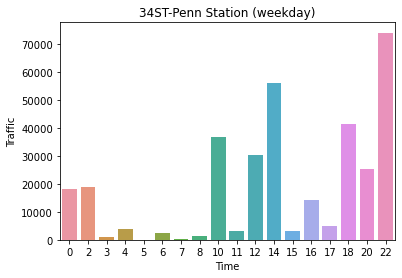

In [34]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_weekday_total_byday)
ax.set_title('34ST-Penn Station (weekday)')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic')

In [35]:
# Weekend data
# Sum over all turnstiles
penn_weekend_total = penn_weekend.groupby(["dow","HOUR"])['AVG_TRAFFIC'].sum().reset_index()
# Average over day
penn_weekend_total_byday = penn_weekend_total.groupby("HOUR")['AVG_TRAFFIC'].mean().reset_index()
penn_weekend_total_byday

,HOUR,AVG_TRAFFIC
0,0,9153.0
1,2,18254.0
2,4,4724.0
3,6,3789.0
4,8,687.0
5,10,5101.5
6,12,5111.0
7,14,19303.0
8,16,11276.5
9,18,30364.0


<AxesSubplot:xlabel='HOUR', ylabel='AVG_TRAFFIC'>

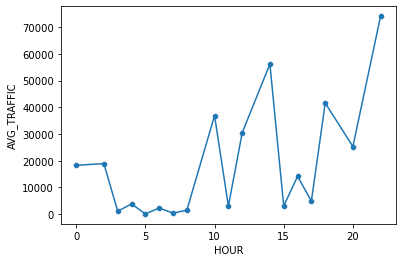

In [36]:
# Try distplot
sns.scatterplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_weekday_total_byday)
sns.lineplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_weekday_total_byday)

Text(0, 0.5, 'Traffic')

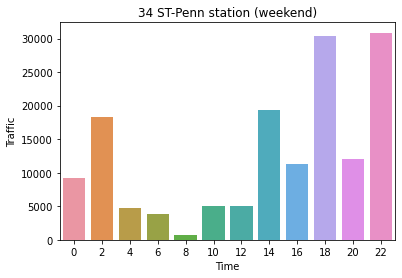

In [37]:
# Barplot showing entries of the hour in a day
ax = sns.barplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_weekend_total_byday)
ax.set_title('34 ST-Penn station (weekend)')
ax.set_xlabel('Time')
ax.set_ylabel('Traffic')

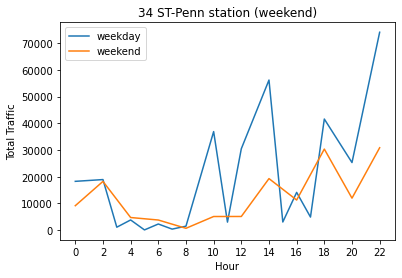

In [38]:
# Plot together for comparison
ax = sns.lineplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_weekday_total_byday, label='weekday')
ax = sns.lineplot(x='HOUR', y= 'AVG_TRAFFIC', data = penn_weekend_total_byday, label='weekend')
ax.set_title('34 ST-Penn station (weekend)')

ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22])
ax.set_xlabel('Hour')
ax.set_ylabel('Total Traffic')
fig.savefig('Traffic_time_Penn.svg', bbox_inches='tight')

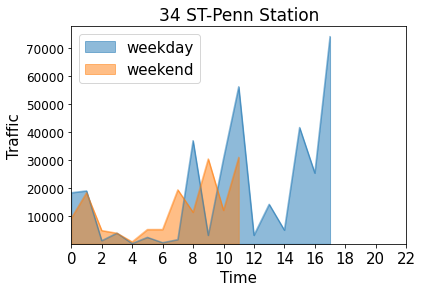

In [39]:
fig, ax = plt.subplots()

## ADJUST HERE -AB
#temp1["AVG_TRAFFIC"].plot.area(label='weekday',alpha=0.5)
#temp2["AVG_TRAFFIC"].plot.area(label='weekday',alpha=0.5)
#New lines:
penn_weekday_total_byday["AVG_TRAFFIC"].plot.area(label='weekday',alpha=0.5)
penn_weekend_total_byday["AVG_TRAFFIC"].plot.area(label='weekend',alpha=0.5)

plt.xlabel('Time', fontsize=15)
plt.ylabel('Traffic', fontsize=15)
plt.title('34 ST-Penn Station',fontsize=17)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.xlim([0,22])
ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22])
ax.set_yticks([1e4,2e4,3e4,4e4,5e4,6e4,7e4])

#changed to .svg -AB
fig.savefig('Traffic_time.svg', bbox_inches='tight')